In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar  # Added missing import
from datetime import datetime

In [4]:
def main():
    # Configuration
    start_date = "2010-01-01"
    transaction_cost = 0.001  # 10bps per trade
    top_sectors_count = 3
    momentum_lookback = 63  # 3 months trading days
    
    # Fetch data
    sector_etfs = ['XLK', 'XLV', 'XLI', 'XLY', 'XLP', 'XLF', 'XLE', 'XLB', 'XLRE', 'XLU']
    benchmark = 'SPY'
    data = fetch_financial_data(sector_etfs + [benchmark], start_date)
    
    # Calculate returns and momentum
    returns = data.pct_change()
    momentum = data.pct_change(periods=momentum_lookback)
    
    # Generate signals and positions
    positions = generate_positions(momentum, sector_etfs, top_sectors_count)
    
    # Calculate strategy returns with transaction costs
    strategy_returns = calculate_strategy_returns(positions, returns, transaction_cost)
    
    # Benchmark returns
    benchmark_returns = returns[benchmark]
    equal_weight_returns = returns[sector_etfs].mean(axis=1)
    
    # Performance analysis
    results = pd.concat([
        calculate_performance_metrics(strategy_returns, 'Momentum Rotation'),
        calculate_performance_metrics(benchmark_returns, 'SPY'),
        calculate_performance_metrics(equal_weight_returns, 'Equal Weight')
    ], axis=1)
    
    # Regime analysis
    regime_df = calculate_regime_analysis(strategy_returns, benchmark_returns)
    
    # Turnover analysis
    turnover_stats = calculate_turnover(positions)
    
    # Print results
    print("Performance Metrics:")
    print(results.T)
    print("\nRegime Analysis:")
    print(regime_df)
    print("\nTurnover Statistics:")
    print(pd.Series(turnover_stats))
    
    # Visualizations
    plot_equity_curve(strategy_returns, benchmark_returns, equal_weight_returns)
    plot_drawdown(strategy_returns, benchmark_returns)
    plot_monthly_returns(strategy_returns)

In [5]:
def fetch_financial_data(tickers, start_date):
    """Fetch financial data with error handling"""
    print(f"Downloading data for {tickers} since {start_date}...")
    try:
        data = yf.download(tickers, start=start_date)['Close']
        if data.isnull().values.any():
            data = data.ffill().bfill()
            print("Handled missing values in price data")
        return data
    except Exception as e:
        raise RuntimeError(f"Data download failed: {str(e)}")

In [6]:
def generate_positions(momentum, sector_etfs, top_count):
    """Generate positions based on momentum ranking"""
    # Monthly ranking at month-end
    monthly_ranks = momentum[sector_etfs].resample('M').last().rank(axis=1, ascending=False)
    top_sectors = monthly_ranks.apply(lambda x: x.nsmallest(top_count).index.tolist(), axis=1)
    
    # Create position matrix
    positions = pd.DataFrame(index=momentum.index, columns=sector_etfs, data=0)
    
    # Assign positions with rebalancing at month-end
    for i in range(1, len(top_sectors)):
        rebalance_date = top_sectors.index[i]
        prev_month_end = top_sectors.index[i-1]
        
        # Equal weight in top sectors
        positions.loc[prev_month_end:rebalance_date, top_sectors.iloc[i]] = 1/top_count
    
    return positions

In [7]:
def calculate_strategy_returns(positions, returns, transaction_cost):
    """Calculate strategy returns with transaction costs"""
    # Pre-cost returns
    raw_returns = (positions.shift(1) * returns[positions.columns]).sum(axis=1)
    
    # Calculate turnover
    trades = positions.diff().abs().sum(axis=1) / 2  # Round-trip trades
    
    # Apply transaction costs
    return raw_returns - trades * transaction_cost

In [8]:
def calculate_performance_metrics(returns, name):
    """Calculate key performance metrics"""
    if len(returns) == 0:
        return pd.Series({
            'CAGR': 0,
            'Sharpe': 0,
            'Max Drawdown': 0,
            'Win Rate': 0,
            'Calmar Ratio': 0
        }, name=name)
    
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding().max()
    drawdown = (cumulative / peak) - 1
    
    metrics = {
        'CAGR': (cumulative.iloc[-1] ** (252/len(returns))) - 1,
        'Sharpe': returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0,
        'Max Drawdown': drawdown.min(),
        'Win Rate': (returns > 0).mean(),
        'Calmar Ratio': -returns.mean() * 252 / drawdown.min() if drawdown.min() < 0 else 0
    }
    return pd.Series(metrics, name=name)

In [9]:
def calculate_regime_analysis(strategy_returns, benchmark_returns):
    """Analyze performance across market regimes"""
    # Define regimes
    rolling_mean = benchmark_returns.rolling(63).mean()
    rolling_std = benchmark_returns.rolling(63).std()
    
    regimes = pd.DataFrame(index=benchmark_returns.index)
    regimes['Bull'] = benchmark_returns > (rolling_mean + rolling_std)
    regimes['Bear'] = benchmark_returns < (rolling_mean - rolling_std)
    regimes['Neutral'] = ~regimes['Bull'] & ~regimes['Bear']
    
    # Calculate regime performance
    results = {}
    for regime in ['Bull', 'Bear', 'Neutral']:
        mask = regimes[regime].dropna()
        if mask.sum() > 10:  # Ensure sufficient data
            regime_strategy = strategy_returns[mask].dropna()
            regime_bench = benchmark_returns[mask].dropna()
            
            if len(regime_strategy) > 10:
                results[regime] = {
                    'Strategy CAGR': calculate_performance_metrics(regime_strategy, '')['CAGR'],
                    'SPY CAGR': calculate_performance_metrics(regime_bench, '')['CAGR'],
                    'Outperformance': calculate_performance_metrics(
                        regime_strategy - regime_bench, '')['CAGR']
                }
    
    return pd.DataFrame(results)

In [10]:
def calculate_turnover(positions):
    """Calculate turnover statistics"""
    daily_turnover = positions.diff().abs().sum(axis=1)
    return {
        'Avg Daily Turnover': daily_turnover.mean(),
        'Max Daily Turnover': daily_turnover.max(),
        'Annual Turnover': daily_turnover.mean() * 252
    }

In [11]:
def plot_equity_curve(strategy, spy, ew):
    """Plot cumulative performance comparison"""
    plt.figure(figsize=(12, 6))
    (1 + strategy).cumprod().plot(label='Momentum Rotation', linewidth=2.5)
    (1 + spy).cumprod().plot(label='SPY', linestyle='--', alpha=0.8)
    (1 + ew).cumprod().plot(label='Equal Weight', linestyle='-.', alpha=0.8)
    
    plt.title('Sector Rotation Strategy Performance', fontsize=14)
    plt.ylabel('Cumulative Return (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('equity_curve.png', dpi=300)
    plt.show()

In [12]:
def plot_drawdown(strategy, spy):
    """Plot drawdown comparison"""
    def calc_drawdown(returns):
        wealth = (1 + returns).cumprod()
        peak = wealth.expanding().max()
        return (wealth / peak) - 1
    
    plt.figure(figsize=(12, 4))
    calc_drawdown(strategy).plot(label='Momentum Rotation', color='#1f77b4')
    calc_drawdown(spy).plot(label='SPY', color='#ff7f0e', alpha=0.8)
    
    plt.title('Strategy Drawdown Comparison', fontsize=14)
    plt.ylabel('Drawdown', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('drawdown_comparison.png', dpi=300)
    plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_24728\2705643396.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date)['Close']
[*********************100%***********************]  11 of 11 completed
C:\Users\hp\AppData\Local\Temp\ipykernel_24728\2153122952.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ranks = momentum[sector_etfs].resample('M').last().rank(axis=1, ascending=False)
C:\Users\hp\AppData\Local\Temp\ipykernel_24728\2153122952.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3333333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  positions.loc[prev_month_end:rebalance_date, top_sectors.iloc[i]] = 1/top_count
C:\Users\hp\AppData\Local\Temp\ipykernel_24728\2153122952.py:16: FutureWarning: Setting an it

Handled missing values in price data
Performance Metrics:
                       CAGR    Sharpe  Max Drawdown  Win Rate  Calmar Ratio
Momentum Rotation  0.365411  1.996804     -0.281549  0.578666      1.153957
SPY                0.138399  0.835195     -0.337173  0.553717      0.429286
Equal Weight       0.117539  0.768756     -0.370480  0.551680      0.335523

Regime Analysis:
                     Bull      Bear   Neutral
Strategy CAGR   25.877193 -0.955530  0.462303
SPY CAGR        43.252168 -0.983285  0.241836
Outperformance  -0.400893  1.598695  0.176295

Turnover Statistics:
Avg Daily Turnover    0.039460
Max Daily Turnover    2.000000
Annual Turnover       9.943992
dtype: float64


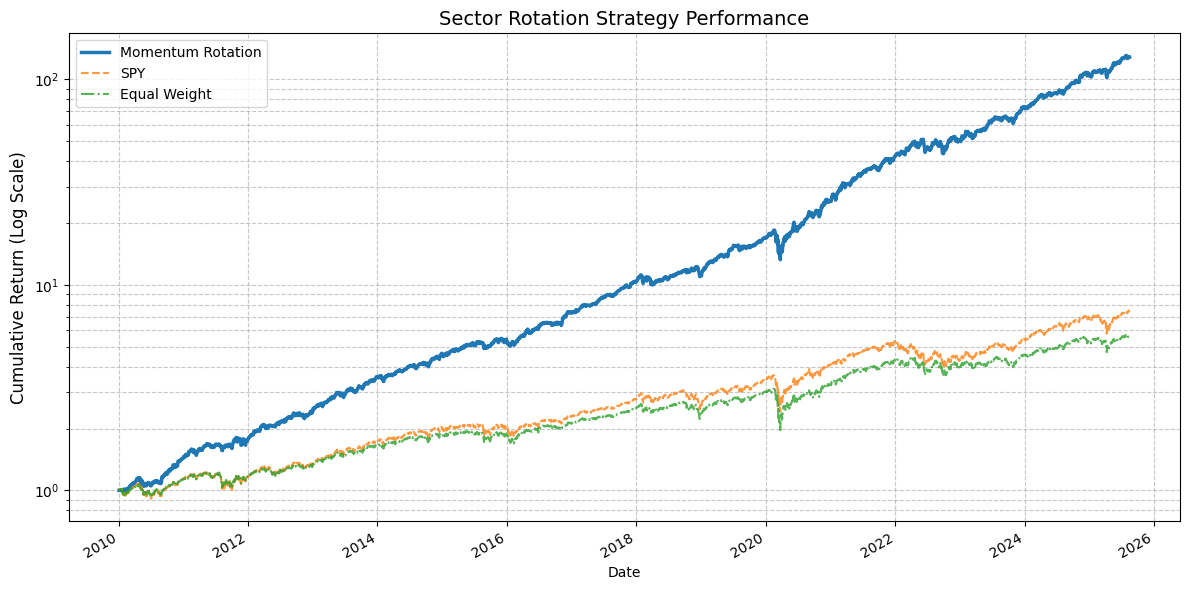

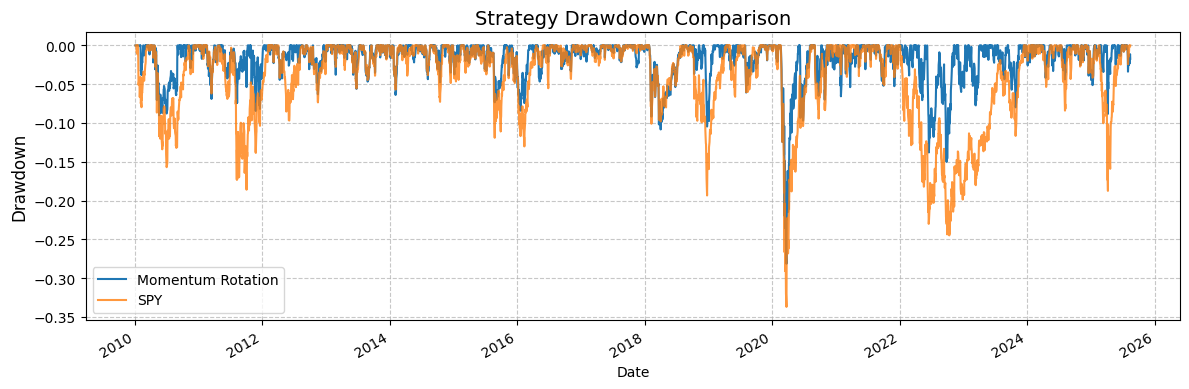

C:\Users\hp\AppData\Local\Temp\ipykernel_24728\2287297532.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_24728\2287297532.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.imshow(returns_matrix.fillna(0), cmap='RdYlGn', aspect='auto', vmin=-0.2, vmax=0.2)


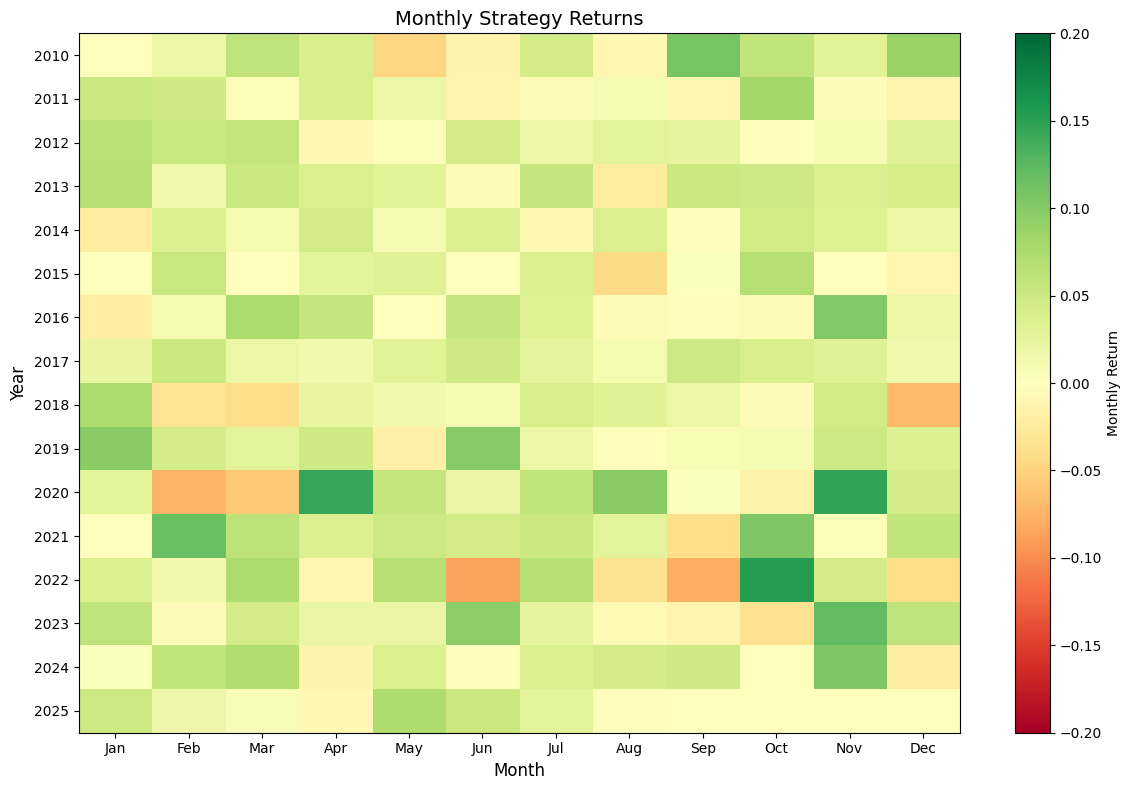

In [13]:
def plot_monthly_returns(returns):
    """Plot monthly returns heatmap"""
    monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    years = sorted(set(date.year for date in monthly_returns.index))
    
    # Prepare matrix for heatmap
    returns_matrix = pd.DataFrame(index=years, columns=[calendar.month_abbr[i] for i in range(1, 13)])
    
    for date in monthly_returns.index:
        year = date.year
        month_abbr = calendar.month_abbr[date.month]
        returns_matrix.loc[year, month_abbr] = monthly_returns.loc[date]
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(returns_matrix.fillna(0), cmap='RdYlGn', aspect='auto', vmin=-0.2, vmax=0.2)
    plt.colorbar(label='Monthly Return')
    
    plt.title('Monthly Strategy Returns', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.xticks(range(12), returns_matrix.columns)
    plt.yticks(range(len(years)), years)
    
    plt.tight_layout()
    plt.savefig('monthly_returns_heatmap.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()